# Lending Club Project

Lending Club é uma empresa dos Estados Unidos que trabalha com empréstimos _peer to peer_ (pessoas para pessoas), onde os investidores fornecem fundos para potenciais pessoas que querem empréstimo e recebem um ganho dependendo do risco que eles assumem (o score de crédito das pessoas que pegam empréstimo).
Lending Club é a "ponte" entre os investidoeres e as pessoas que precisam de um empréstimo. Para mais informações veja esse artigo da wikipédia sobre a empresa.

![Image of Yaktocat](http://echeck.org/wp-content/uploads/2016/12/Showing-how-the-lending-club-works-and-makes-money-1.png)

In [1]:
#importe suas libs aqui

In [2]:
# Import our libraries we are going to use for our data analysis.
import lightgbm as lgb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plotly visualizations
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from sklearn.metrics import confusion_matrix

# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE

# Other Libraries
import time

/home/bahbbc/.local/share/virtualenvs/lending_challenge-tdJTq15Q/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/home/bahbbc/.local/share/virtualenvs/lending_challenge-tdJTq15Q/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [3]:
#import os dados

In [4]:
df = pd.read_csv('lending-club-loan-data-light/small_loan.csv')

original_df = df.copy()

df.head()

/home/bahbbc/.local/share/virtualenvs/lending_challenge-tdJTq15Q/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (113,124,125,126,129,130,131,134,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.



,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,issue_month,issue_year
0,0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2018
1,1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2018
2,2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2018
3,3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2018
4,4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,...,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,Dec,2018


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938821 entries, 0 to 938820
Columns: 148 entries, Unnamed: 0 to issue_year
dtypes: float64(106), int64(6), object(36)
memory usage: 1.0+ GB


In [6]:
df.shape

(938821, 148)

In [7]:
df = df[:500000]

In [8]:
df.to_csv('lending_club_challenge.csv')

## EDA

In [9]:
#antes vamos renomear alguns campos

In [10]:
# Replace the name of some columns
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# Drop irrelevant columns
df.drop(['id', 'member_id', 'emp_title', 'url', 'desc', 'zip_code', 'title'], axis=1, inplace=True)

- Quanto foi solicitado pelas pessoas que pediram empréstimo? (loan_amount)
- Quanto foi emprestado pelas pessoas? (funded_amount)
- Quanto foi usado pelos investidores (investor_funds)

(veja se esses valores batem)

Text(0.5, 1.0, 'Total committed by Investors')

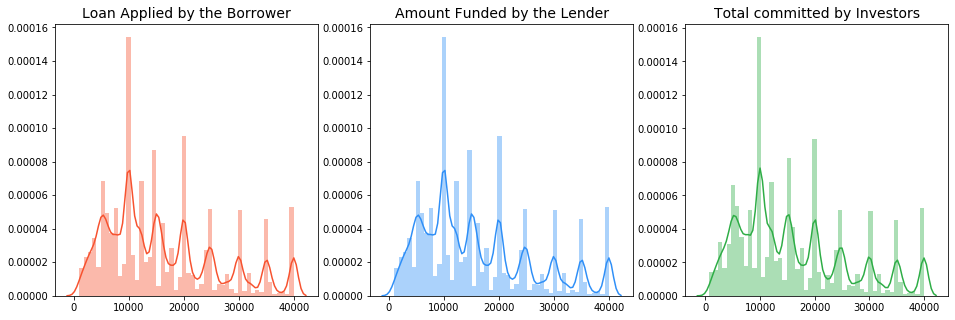

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))




loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = df["investor_funds"].values


sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

Quais os anos que os empréstimos foram gerados?

In [12]:
#plot os anos onde os empréstimos foram gerados

In [13]:
# Lets' transform the issue dates by year.
df['issue_d'].head()
dt_series = pd.to_datetime(df['issue_d'])
df['year'] = dt_series.dt.year
df['issue_month']= dt_series.dt.month

Text(0, 0.5, 'Average loan amount issued')

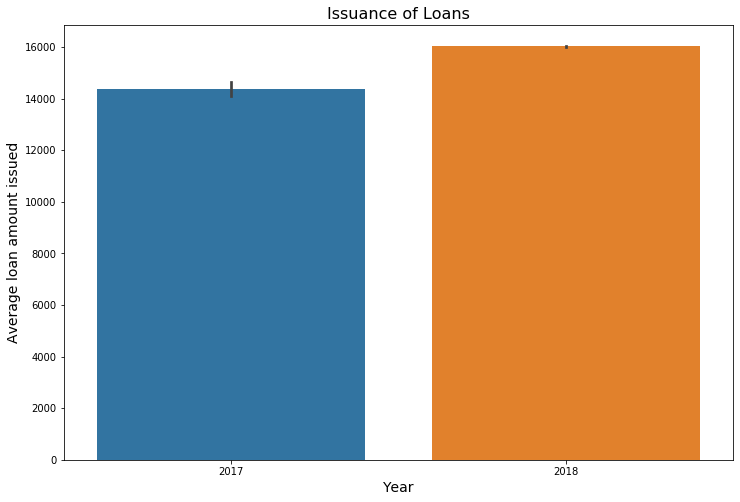

In [14]:
# The year of 2015 was the year were the highest amount of loans were issued 
# This is an indication that the economy is quiet recovering itself.
plt.figure(figsize=(12,8))
sns.barplot('year', 'loan_amount', data=df, palette='tab10')
plt.title('Issuance of Loans', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average loan amount issued', fontsize=14)

### Bons e maus pagadores

O que acontece quando uma das pessoas não paga o empréstimo? Quais as possíveis categorias do empréstimo que possuem?

Veja na categoria `loan_status`

In [15]:
df["loan_status"].value_counts()

Current               439946
Fully Paid             41783
Charged Off             7444
Late (31-120 days)      6577
In Grace Period         2914
Late (16-30 days)       1327
Default                    9
Name: loan_status, dtype: int64

Vamos considerar as categorias `Charged Off`, `Default`, `Does not meet the credit policy. Status:Charged Off`, `In Grace Period`, `Late (16-30 days)`, `Late (31-120 days)`

In [16]:
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

In [17]:
#plot graficos para verificar a proporção de mau pagadores do dataset e também o montante de mau pagadores por ano

[Text(0, 0.5, '(%)')]

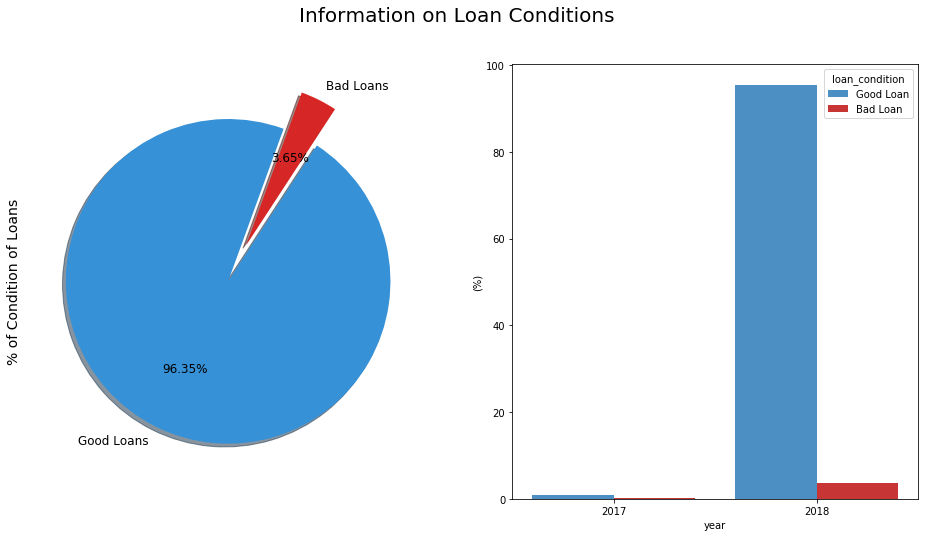

In [18]:
f, ax = plt.subplots(1,2, figsize=(16,8))

colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

plt.suptitle('Information on Loan Conditions', fontsize=20)

df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, colors=colors, 
                                             labels=labels, fontsize=12, startangle=70)


# ax[0].set_title('State of Loan', fontsize=16)
ax[0].set_ylabel('% of Condition of Loans', fontsize=14)

# sns.countplot('loan_condition', data=df, ax=ax[1], palette=colors)
# ax[1].set_title('Condition of Loans', fontsize=20)
# ax[1].set_xticklabels(['Good', 'Bad'], rotation='horizontal')
palette = ["#3791D7", "#E01E1B"]

sns.barplot(x="year", y="loan_amount", hue="loan_condition", data=df, palette=palette, estimator=lambda x: len(x) / len(df) * 100)
ax[1].set(ylabel="(%)")

In [19]:
### Verificar a quantidade de dinheiro emprestado por região

In [20]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    


df['region'] = df['addr_state'].apply(finding_regions)

In [21]:
# This code will take the current date and transform it into a year-month format
df['complete_date'] = pd.to_datetime(df['issue_d'])

group_dates = df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amount'] = group_dates['loan_amount']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amount']])

Text(0.5, 1.0, 'Loans issued by Region')

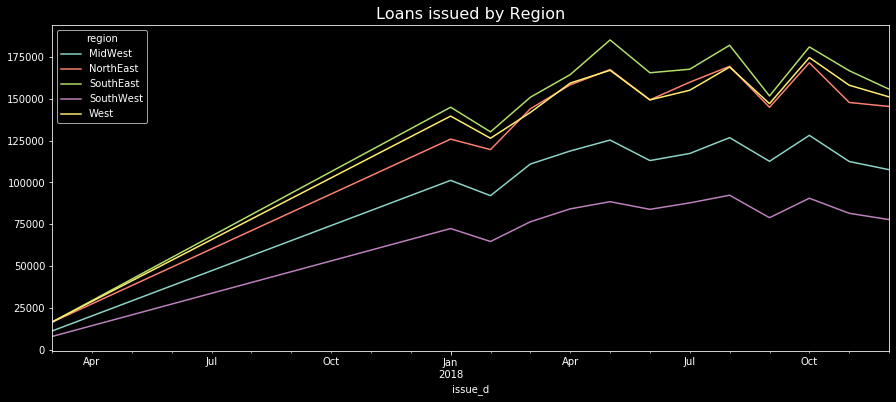

In [22]:
plt.style.use('dark_background')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amount.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=False, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

In [23]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

In [24]:
df.groupby('region').interest_rate.mean()

region
MidWest      12.671772
NorthEast    12.805007
SouthEast    12.845473
SouthWest    12.625146
West         12.635701
Name: interest_rate, dtype: float64

Verificar as taxas do empréstimo (interest_rate), taxa de empregos por região (emp_length_int), taxa de dívida por renda (dti), renda mensal (annual_income) por região.

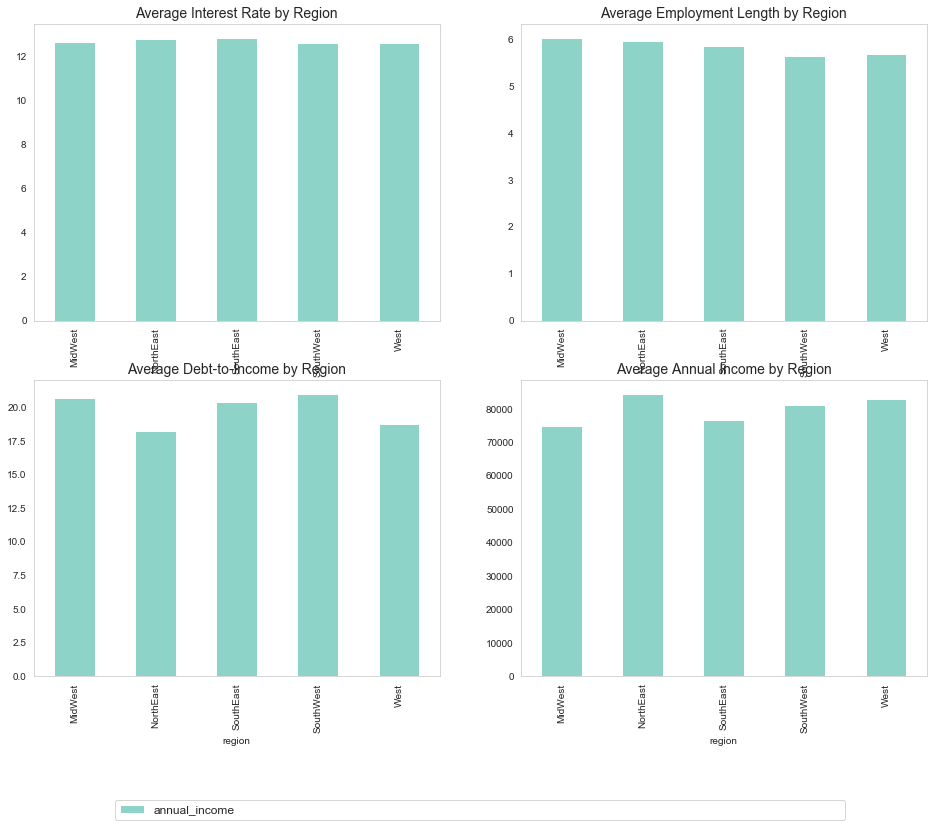

In [25]:
# Loan issued by Region and by Credit Score grade
# Change the colormap for tomorrow!

sns.set_style('whitegrid')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
cmap = plt.cm.inferno

by_interest_rate = df.groupby('region').interest_rate.mean()
by_interest_rate.plot(kind='bar', grid=False, legend=False, ax=ax1, figsize=(16,12))
ax1.set_title('Average Interest Rate by Region', fontsize=14)


by_employment_length = df.groupby('region').emp_length_int.mean()
by_employment_length.plot(kind='bar', grid=False, legend=False, ax=ax2, figsize=(16,12))
ax2.set_title('Average Employment Length by Region', fontsize=14)
# plt.xlabel('Year of Issuance', fontsize=14)

by_dti = df.groupby('region').dti.mean()
by_dti.plot(kind='bar', grid=False, legend=False, ax=ax3, figsize=(16,12))
ax3.set_title('Average Debt-to-Income by Region', fontsize=14)

by_income = df.groupby('region').annual_income.mean()
by_income.plot(kind='bar', grid=False, ax=ax4, legend=False, figsize=(16,12))
ax4.set_title('Average Annual Income by Region', fontsize=14)
ax4.legend(bbox_to_anchor=(-1.0, -0.5, 1.8, 0.1), loc=10,prop={'size':12},
           ncol=5, mode="expand", borderaxespad=0.)

- The number of loans that were classified as bad loans for each region by its loan status. (This will be shown in a dataframe below.)
- This won't give us the exact reasons why a loan is categorized as a bad loan (other variables that might have influence the condition of the loan) but it will give us a deeper insight on the level of risk in a particular region.

In [26]:
# We have 67429 loans categorized as bad loans
badloans_df = df.loc[df["loan_condition"] == "Bad Loan"]

# loan_status cross
loan_status_cross = pd.crosstab(badloans_df['region'], badloans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(badloans_df['region'], badloans_df['loan_status'])


# Round our values
loan_status_cross['Charged Off'] = loan_status_cross['Charged Off'].apply(lambda x: round(x, 2))
loan_status_cross['Default'] = loan_status_cross['Default'].apply(lambda x: round(x, 2))
loan_status_cross['In Grace Period'] = loan_status_cross['In Grace Period'].apply(lambda x: round(x, 2))
loan_status_cross['Late (16-30 days)'] = loan_status_cross['Late (16-30 days)'].apply(lambda x: round(x, 2))
loan_status_cross['Late (31-120 days)'] = loan_status_cross['Late (31-120 days)'].apply(lambda x: round(x, 2))


number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1) 
# number_of_badloans
number_of_loanstatus

loan_status,Charged Off,Default,In Grace Period,Late (16-30 days),Late (31-120 days),Total
region,,,,,,
MidWest,1229,2,449,193,997,2870
NorthEast,1682,2,732,346,1565,4327
SouthEast,1898,1,759,337,1692,4687
SouthWest,913,2,357,161,814,2247
West,1722,2,617,290,1509,4140


In [27]:
# Average interest rates clients pay
print(df['interest_rate'].mean())
# Average annual income of clients
print(df['annual_income'].mean())

12.731111080000002
80121.68409762


### Vamos avaliar o score das pessoas

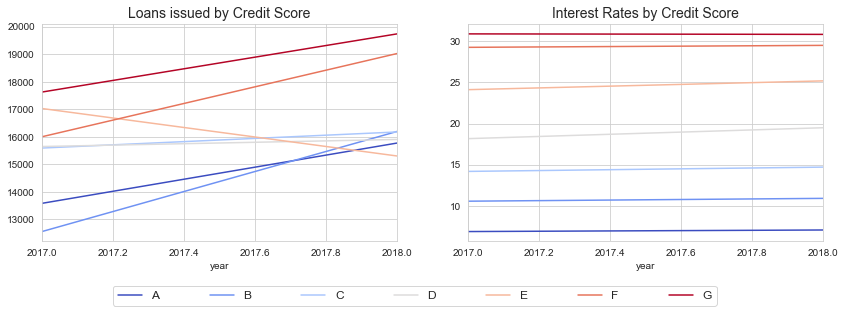

In [28]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.coolwarm

by_credit_score = df.groupby(['year', 'grade']).loan_amount.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['year', 'grade']).interest_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

Text(0, 0.5, 'Interest Rate (%)')

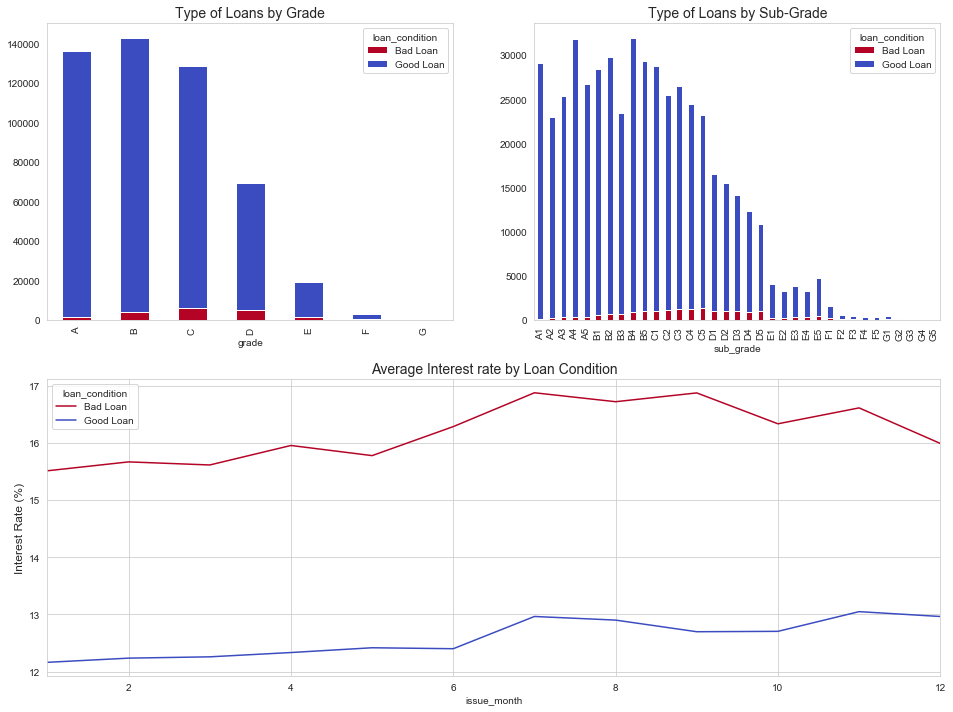

In [29]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.coolwarm_r

loans_by_region = df.groupby(['grade', 'loan_condition']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_condition']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['issue_month', 'loan_condition']).interest_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

### O que determina um bom ou mau empréstimo?

In [30]:
# Just get me the numeric variables
numeric_variables = df.select_dtypes(exclude=["object"])

Vamos verificar a correlação das variáveis

In [31]:
# We will use df_correlations dataframe to analyze our correlations.


df_correlations = df.corr()


trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                  colorscale=[[0.0, 'rgb(165,0,38)'], 
                              [0.1111111111111111, 'rgb(215,48,39)'], 
                              [0.2222222222222222, 'rgb(244,109,67)'], 
                              [0.3333333333333333, 'rgb(253,174,97)'], 
                              [0.4444444444444444, 'rgb(254,224,144)'], 
                              [0.5555555555555556, 'rgb(224,243,248)'], 
                              [0.6666666666666666, 'rgb(171,217,233)'], 
                              [0.7777777777777778, 'rgb(116,173,209)'], 
                              [0.8888888888888888, 'rgb(69,117,180)'], 
                              [1.0, 'rgb(49,54,149)']],
            colorbar = dict(
            title = 'Level of Correlation',
            titleside = 'top',
            tickmode = 'array',
            tickvals = [-0.52,0.2,0.95],
            ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
            ticks = 'outside'
        )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')


In [32]:
# vamos verificar uma quantidade menor de variáveis

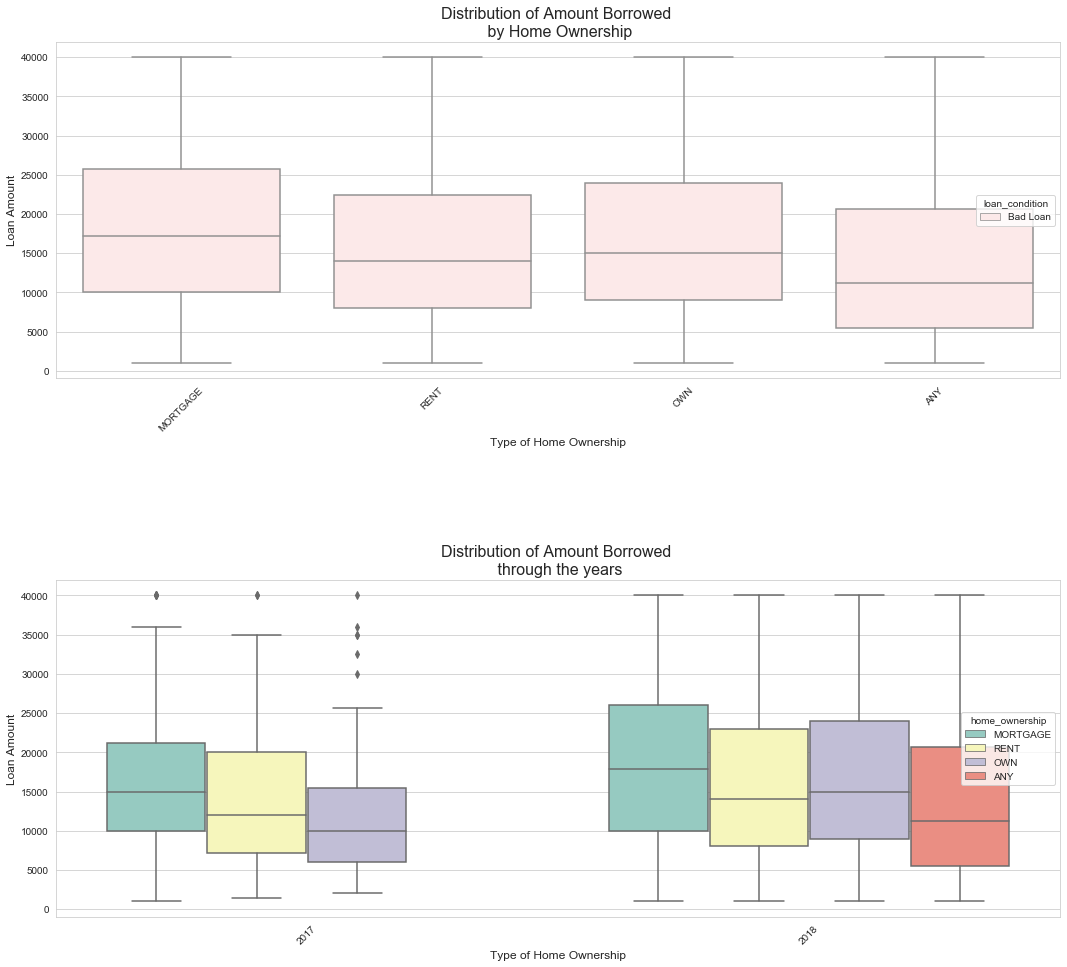

In [33]:
plt.figure(figsize=(18,18))

# Create a dataframe for bad loans
bad_df = df.loc[df['loan_condition'] == 'Bad Loan']

plt.subplot(211)
g = sns.boxplot(x='home_ownership', y='loan_amount', hue='loan_condition',
               data=bad_df, color='r')

g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("Type of Home Ownership", fontsize=12)
g.set_ylabel("Loan Amount", fontsize=12)
g.set_title("Distribution of Amount Borrowed \n by Home Ownership", fontsize=16)



plt.subplot(212)
g1 = sns.boxplot(x='year', y='loan_amount', hue='home_ownership',
               data=bad_df, palette="Set3")
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("Type of Home Ownership", fontsize=12)
g1.set_ylabel("Loan Amount", fontsize=12)
g1.set_title("Distribution of Amount Borrowed \n through the years", fontsize=16)


plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

In [34]:
df['term'].value_counts()

 36 months    348274
 60 months    151726
Name: term, dtype: int64

In [35]:
df['interest_rate'].describe()
# Average interest is 13.26% Anything above this will be considered of high risk let's see if this is true.
df['interest_payments'] = np.nan
lst = [df]

for col in lst:
    col.loc[col['interest_rate'] <= 13.23, 'interest_payments'] = 'Low'
    col.loc[col['interest_rate'] > 13.23, 'interest_payments'] = 'High'
    
df.head()

,Unnamed: 0,loan_amount,funded_amount,investor_funds,term,interest_rate,installment,grade,sub_grade,emp_length,...,settlement_percentage,settlement_term,issue_month,issue_year,year,loan_condition,region,complete_date,emp_length_int,interest_payments
0,0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,10+ years,...,NaN,NaN,12,2018,2018,Good Loan,NorthEast,2018-12-01,10.0,High
1,1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,10+ years,...,NaN,NaN,12,2018,2018,Good Loan,SouthEast,2018-12-01,10.0,High
2,2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,6 years,...,NaN,NaN,12,2018,2018,Good Loan,MidWest,2018-12-01,6.0,High
3,3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,10+ years,...,NaN,NaN,12,2018,2018,Good Loan,West,2018-12-01,10.0,High
4,4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,10+ years,...,NaN,NaN,12,2018,2018,Good Loan,NorthEast,2018-12-01,10.0,High


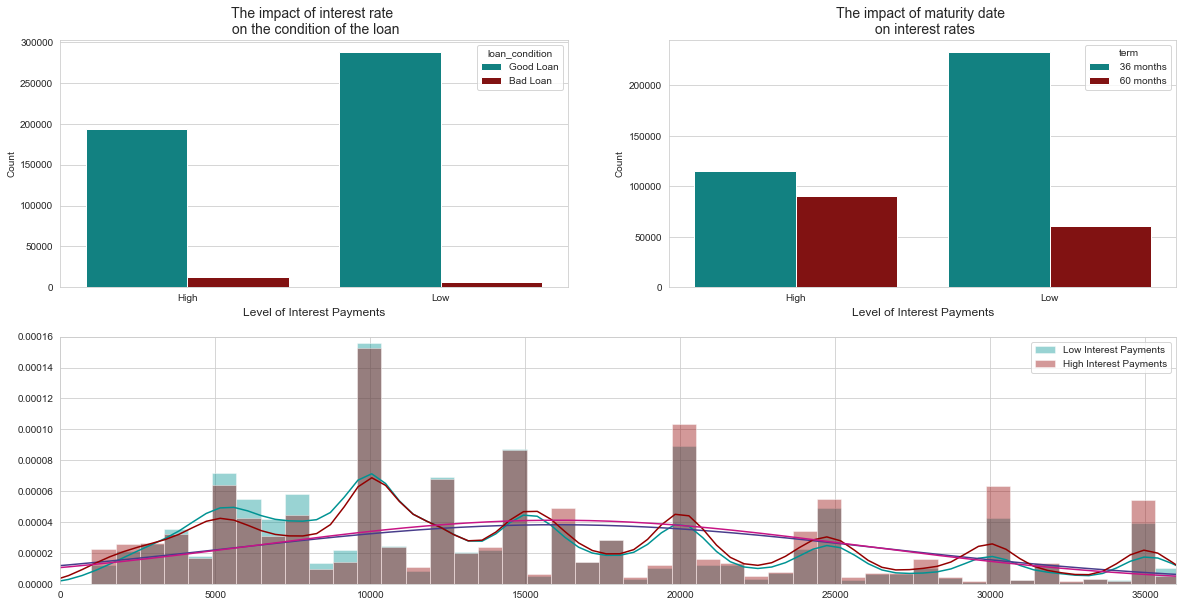

In [36]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#009393', '#930000']
plt.subplot(221)
ax = sns.countplot(x='interest_payments', data=df, 
                  palette=palette, hue='loan_condition')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='interest_payments', data=df, 
                   palette=palette, hue='term')

ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')


plt.subplot(212)
low = df['loan_amount'].loc[df['interest_payments'] == 'Low'].values
high = df['loan_amount'].loc[df['interest_payments'] == 'High'].values


ax2= sns.distplot(low, color='#009393', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#930000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()


plt.show()


In [37]:
# motivo do empréstimo

In [38]:
df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(df['loan_condition'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=purpose,
    y=purpose_bad_loans,
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose,
    y=purpose_good_loans,
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

## Feature engineering

Lembre-se que a feature engineering depende bastante do algoritmo utilizado.

Passo a passo:
    
- Existem variáveis redundantes, ou que não tem efeito sobre as condições do empréstimo. Elimine-as.
- Lembre-se que o dataset está desbalanceado.
- Dependendo do algoritmo utilizado (ou caso deseje utilizar mais de um é necessário fazer o enconde das variáveis categóricas e reescalar as variáveis numéricas.


In [39]:
df["loan_amount"].values

array([ 2500, 30000,  5000, ..., 20000, 17000, 10000])

In [40]:
# Copy Dataframe
complete_df = df.copy()


# Handling Missing Numeric Values

# Transform Missing Values for numeric dataframe
# Nevertheless check what these variables mean tomorrow in the morning.
for col in ('dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_12m',
           'open_il_24m', 'inq_last_12m', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
           'mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'total_bal_il', 'tot_coll_amt',
           'tot_cur_bal', 'total_rev_hi_lim', 'revol_util', 'collections_12_mths_ex_med', 'open_acc', 'inq_last_6mths',
           'verification_status_joint', 'acc_now_delinq'):
    complete_df[col] = complete_df[col].fillna(0)
    


# # Get the mode of next payment date and last payment date and the last date credit amount was pulled   
complete_df["next_pymnt_d"] = complete_df.groupby("region")["next_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_pymnt_d"] = complete_df.groupby("region")["last_pymnt_d"].transform(lambda x: x.fillna(x.mode))
complete_df["last_credit_pull_d"] = complete_df.groupby("region")["last_credit_pull_d"].transform(lambda x: x.fillna(x.mode))
complete_df["earliest_cr_line"] = complete_df.groupby("region")["earliest_cr_line"].transform(lambda x: x.fillna(x.mode))
complete_df["dti"] = complete_df.groupby("region")["dti"].transform(lambda x: x.fillna(x.mode))

# # Get the mode on the number of accounts in which the client is delinquent
complete_df["pub_rec"] = complete_df.groupby("region")["pub_rec"].transform(lambda x: x.fillna(x.median()))

# # Get the mean of the annual income depending in the region the client is located.
complete_df["annual_income"] = complete_df.groupby("region")["annual_income"].transform(lambda x: x.fillna(x.mean()))

# Get the mode of the  total number of credit lines the borrower has 
complete_df["total_acc"] = complete_df.groupby("region")["total_acc"].transform(lambda x: x.fillna(x.median()))

# Mode of credit delinquencies in the past two years.
complete_df["delinq_2yrs"] = complete_df.groupby("region")["delinq_2yrs"].transform(lambda x: x.fillna(x.mean()))

In [41]:
# Drop these variables before scaling but don't drop these when we perform feature engineering on missing values.
# Columns to delete or fix: earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d, verification_status_joint

# ---->>>> Fix the problems shown during scaling with the columns above.

complete = complete_df[['loan_amount', 'term', 'interest_rate', 'installment', 'grade',
       'home_ownership', 'annual_income', 'verification_status', 'pymnt_plan', 'purpose',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mths_since_last_delinq', 'addr_state']]

In [42]:
numeric = ['loan_amount', 'interest_rate', 'installment',
       'annual_income', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'mths_since_last_delinq']

In [43]:
categorical = ['term',
 'grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state']

In [44]:
complete.isnull().sum().max()

0

In [45]:
len(complete_df['loan_condition'])
# Loan Ratios (Imbalanced classes)
complete_df['loan_condition'].value_counts()/len(complete_df['loan_condition']) * 100

Good Loan    96.3458
Bad Loan      3.6542
Name: loan_condition, dtype: float64

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(complete, complete_df['loan_condition'], 
                                                    test_size = 0.2, random_state = 0, 
                                                    stratify=complete_df['loan_condition'])

In [47]:
X_train.columns

Index(['loan_amount', 'term', 'interest_rate', 'installment', 'grade',
       'home_ownership', 'annual_income', 'verification_status', 'pymnt_plan',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'mths_since_last_delinq', 'addr_state'],
      dtype='object')

In [48]:
from pandas import Categorical, get_dummies
from sklearn.base import TransformerMixin, BaseEstimator


class CategoricalWarrior(BaseEstimator, TransformerMixin):
    """One hot encoder for all categorical features"""
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = X.copy()
        for l in self.attribute_names:
            dummies = pd.get_dummies(df[l], drop_first=True)
            df = df.join(dummies)
            df.drop(l, inplace=True, axis=1)
        return df

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [50]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric)),
    ('scaler', StandardScaler()),
])


In [51]:
categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical)), # We will have to write the categorical columns manually and see if it works.
    ('encoder', CategoricalWarrior(categorical)),
])


In [52]:
# Combine both Pipelines into one array
combined_pipeline = FeatureUnion(transformer_list=[
    ('numeric_pipeline', numeric_pipeline),
    ('categorical_pipeline', categorical_pipeline)
])

X_train = combined_pipeline.fit_transform(X_train)
X_test = combined_pipeline.transform(X_test)

In [53]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
# log_reg_sm = LogisticRegression()
log_reg.fit(X_train, y_train)

/home/bahbbc/.local/share/virtualenvs/lending_challenge-tdJTq15Q/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)

In [55]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ['0', '1']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[ 2515  1139]
 [35664 60682]]


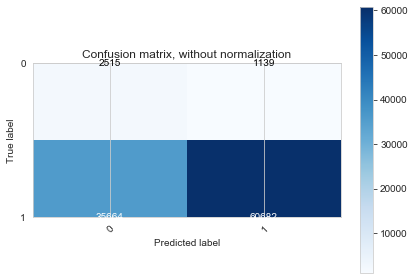

In [56]:
_ = plot_confusion_matrix(y_test, y_pred,
                      title='Confusion matrix, without normalization')

Devido a um erro de versão da lib, a mariz ficou cagada :(

Normalized confusion matrix
[[0.68828681 0.31171319]
 [0.37016586 0.62983414]]


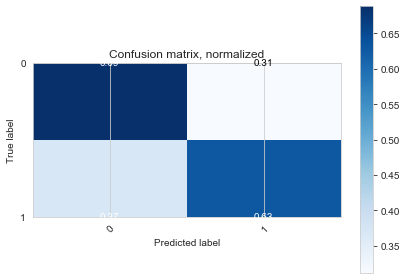

In [57]:
_ = plot_confusion_matrix(y_test, y_pred, normalize=True,
                      title='Confusion matrix, normalized')

In [58]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [62]:
y_test.map('Good Loan', 1)

486250    Good Loan
444937    Good Loan
144472    Good Loan
74524     Good Loan
371227    Good Loan
            ...    
486025     Bad Loan
25648     Good Loan
391405    Good Loan
463543    Good Loan
354397    Good Loan
Name: loan_condition, Length: 100000, dtype: object

In [60]:
fpr, tpr, roc = roc_curve(y_test, y_pred_proba[:, 1])

ValueError: Data is not binary and pos_label is not specified

In [ ]:
auc = roc_auc_score(y_test, y_pred_proba[:,1])

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

*Atenção!*

Essa não é a melhor das soluções, mas é a que possui várias coisas vistas durante o curso! Utilize outras metodologias para melhorar essa respota, como Grid Search, XGBoost, LightGBM e outras features.

Como visto em aula é importante utilizar uma única métrica para comparar os algoritmos, como o AUC.